### Assignment: Feature Engineering

Create the following features and determine if they improve model accuracy. 

1. Create 2nd and 3rd order polynomial columns for 'hd'
2. Then, try combining the 'cd' and 'multi' features: If 'cd' AND 'multi' both equal "yes" then 1, else 0.
3. Finally, bin ram values into '<=4', '8', and '16+' - does this improve model fit?
4. Create Dummy Variables for any categorical columns

Remove any features that don't improve model accuracy and score your final model on the test dataset.

In [36]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import numpy as np

computers = pd.read_csv("../Data/Computers.csv")

computers.tail()

,price,speed,hd,ram,screen,cd,multi,premium,ads,trend
6254,1690,100,528,8,15,no,no,yes,39,35
6255,2223,66,850,16,15,yes,yes,yes,39,35
6256,2654,100,1200,24,15,yes,no,yes,39,35
6257,2195,100,850,16,15,yes,no,yes,39,35
6258,2490,100,850,16,17,yes,no,yes,39,35


### Feature Engineering

In [37]:
computers.assign(
    hd2 = computers.hd ** 2,
    hd3 = computers.hd ** 3
)


,price,speed,hd,ram,screen,cd,multi,premium,ads,trend,hd2,hd3
0,1499,25,80,4,14,no,no,yes,94,1,6400,512000
1,1795,33,85,2,14,no,no,yes,94,1,7225,614125
2,1595,25,170,4,15,no,no,yes,94,1,28900,4913000
3,1849,25,170,8,14,no,no,no,94,1,28900,4913000
4,3295,33,340,16,14,no,no,yes,94,1,115600,39304000
...,...,...,...,...,...,...,...,...,...,...,...,...
6254,1690,100,528,8,15,no,no,yes,39,35,278784,147197952
6255,2223,66,850,16,15,yes,yes,yes,39,35,722500,614125000
6256,2654,100,1200,24,15,yes,no,yes,39,35,1440000,1728000000
6257,2195,100,850,16,15,yes,no,yes,39,35,722500,614125000


In [38]:
computers.ram.max()

32

In [100]:
ram_dict = {
    2:"<=4",
    4:"<=4",
    8:"8",
    16:"16+",
    32:"16+",
}

computers_eng = (
    pd.get_dummies(
        computers.assign(
            hd2 = computers["hd"] ** 2,
            hd3 = computers["hd"] ** 3,
            # ports = np.where((computers["cd"] == "yes") & (computers["multi"] == "yes"), 1, 0), 
            ram_categories = computers["ram"].map(ram_dict),
        ),
    drop_first=True    
    ).astype(int)
)

computers_eng.head()


,price,speed,hd,ram,screen,ads,trend,hd2,hd3,cd_yes,multi_yes,premium_yes,ram_categories_8,ram_categories_<=4
0,1499,25,80,4,14,94,1,6400,512000,0,0,1,0,1
1,1795,33,85,2,14,94,1,7225,614125,0,0,1,0,1
2,1595,25,170,4,15,94,1,28900,4913000,0,0,1,0,1
3,1849,25,170,8,14,94,1,28900,4913000,0,0,0,1,0
4,3295,33,340,16,14,94,1,115600,39304000,0,0,1,0,0


### Data Splitting

In [101]:
from sklearn.model_selection import train_test_split


features = ["speed", "hd", "ram", "screen", "ads", "trend"]

X = sm.add_constant(computers_eng.drop("price", axis=1))
# X = sm.add_constant(computers[features])
y = np.log(computers["price"])

# Test Split
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=12345)


### Cross-Validation

In [102]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_absolute_error as mae



kf = KFold(n_splits=5, shuffle=True, random_state=2023)

# Create a list to store validation scores for each fold
cv_lm_r2s = []
cv_lm_mae = []

# Loop through each fold in X and y
for train_ind, val_ind in kf.split(X, y):
    # Subset data based on CV folds
    X_train, y_train = X.iloc[train_ind], y.iloc[train_ind]
    X_val, y_val = X.iloc[val_ind], y.iloc[val_ind]
    # Fit the Model on fold's training data
    model = sm.OLS(y_train, X_train).fit()
    # Append Validation score to list 
    cv_lm_r2s.append(r2(y_val, model.predict(X_val),))
    cv_lm_mae.append(mae(y_val, model.predict(X_val),))

print("All Validation R2s: ", [round(x, 3) for x in cv_lm_r2s])
print(f"Cross Val R2s: {round(np.mean(cv_lm_r2s), 3)} +- {round(np.std(cv_lm_r2s), 3)}")

print("All Validation MAEs: ", [round(x, 3) for x in cv_lm_mae])
print(f"Cross Val MAEs: {round(np.mean(cv_lm_mae), 3)} +- {round(np.std(cv_lm_mae), 3)}")

All Validation R2s:  [0.805, 0.792, 0.804, 0.816, 0.802]
Cross Val R2s: 0.804 +- 0.008
All Validation MAEs:  [0.086, 0.09, 0.088, 0.085, 0.087]
Cross Val MAEs: 0.087 +- 0.002


In [99]:
def residual_analysis_plots(model):
    
    import scipy.stats as stats
    import matplotlib.pyplot as plt
    
    predictions = model.predict()
    residuals = model.resid
    
    fig, ax = plt.subplots(1, 2, sharey="all", figsize=(10, 6))
    
    sns.scatterplot(x=predictions, y=residuals, ax=ax[0], alpha=.3)
    ax[0].set_title("Residual Plot")
    ax[0].set_xlabel("Prediction")
    ax[0].set_ylabel("Residuals")
    
    stats.probplot(residuals, dist="norm", plot=ax[1])
    ax[1].set_title("Normal Q-Q Plot")   


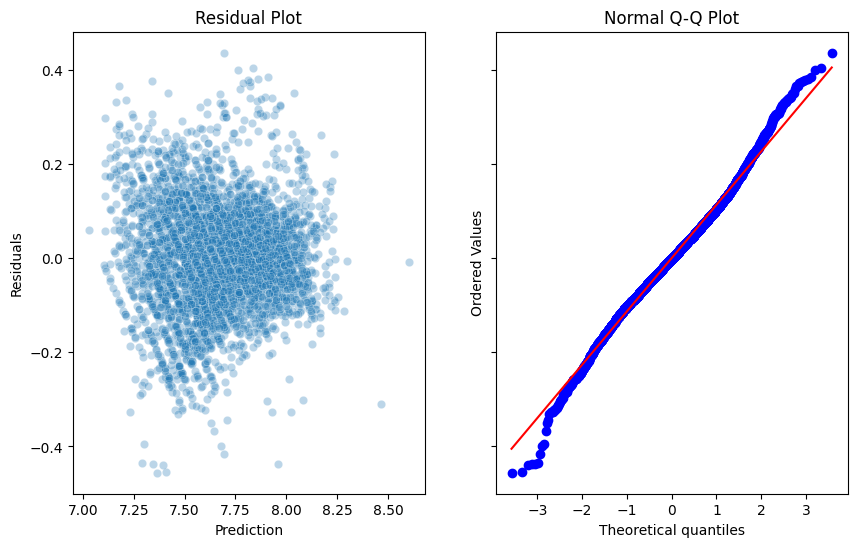

In [92]:
residual_analysis_plots(model)

### Fit On All Training Data

In [103]:
model = sm.OLS(y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     1599.
Date:                Fri, 07 Nov 2025   Prob (F-statistic):               0.00
Time:                        15:59:50   Log-Likelihood:                 3802.6
No. Observations:                5007   AIC:                            -7577.
Df Residuals:                    4993   BIC:                            -7486.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  6.9271      0.035    195.339      0.000       6.858       6.997
speed                  0.0039   8.66e-05     45.250      0.000       0.004       0.004
hd                     0.0011   4.93e-05     21.779      0.000       0.001       0.001
ram                    0.0159      0.001     13.563      0.000       0.014       0.018
screen                 0.0490      0.002     26.641      0.000       0.045       0.053
ads                    0.0002   2.44e-05      7.044      0.000       0.000       0.000
trend                 -0.0240      0.000    -78.698      0.000      -0.025      -0.023
hd2                -9.258e-07   7.05e-08    -13.135      0.000   -1.06e-06   -7.88e-07
hd3                 3.022e-10   3.08e-11      9.802      0.000    2.42e-10    3.63e-10
cd_yes                 0.0370      0.004      8.358      0.000       0.028       0.046
multi_yes              0.0486      0.005      9.255      0.000       0.038       0.059
premium_yes           -0.2465      0.006    -42.987      0.000      -0.258      -0.235
ram_categories_8      -0.0340      0.011     -3.016      0.003      -0.056      -0.012
ram_categories_<=4    -0.0746      0.016     -4.618      0.000      -0.106      -0.043
==============================================================================
Omnibus:                       90.707   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              171.040
Skew:                           0.098   Prob(JB):                     7.23e-38
Kurtosis:                       3.884   Cond. No.                     1.02e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.02e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Test Performance

In [104]:
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_absolute_error as mae

print(f"Test R2: {r2(y_test, model.predict(X_test))}")
print(f"Test MAE: {mae(y_test, model.predict(X_test))}")

Test R2: 0.8112261550414344
Test MAE: 0.08705759685308029


In [106]:
!git add 06_feature_engineering_assignment.ipynb
!git commit -m "06_feature_engineering_assignment"
!git push origin master

On branch master
Your branch is ahead of 'origin/master' by 1 commit.
  (use "git push" to publish your local commits)

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   01_EDA_assignments.ipynb
	modified:   03_multiple_regression_assignments.ipynb
	modified:   ../Demo Notebooks/01_EDA_Demos.ipynb
	modified:   ../Demo Notebooks/02_Simple_Regression_Case_Study.ipynb
	modified:   ../Demo Notebooks/06_feature_engineering_demos.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	../../../DataScienceinPythonRegression-230823-140728.pdf
	../.DS_Store
	../.ipynb_checkpoints/
	.DS_Store
	.DS_Store:Zone.Identifier
	.ipynb_checkpoints/
	01_EDA_solutions.ipynb
	02_simple_regression_assignments.ipynb
	02_simple_regression_solutions.ipynb
	03_multiple_regression_solutions.ipynb
	04_assumptions_assignments.ipynb
	05_data_splitting_soluti